# Ungraded Lab: Building Models for the IMDB Reviews Dataset

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Natural_Language_Processing_in_TensorFlow/Week3/Labs/C3_W3_Lab_4_imdb_reviews_with_GRU_LSTM_Conv1D.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will build four models and train it on the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) with full word encoding. These use different layers after the embedding namely `Flatten`, `LSTM`, `GRU`, and `Conv1D`. You will compare the performance and see which architecture might be best for this particular dataset. Let's begin!

## Imports

You will first import common libraries that will be used throughout the exercise.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from keras import utils, Sequential, Input, layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-13 14:03:34.071254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download and Prepare the Dataset

Next, you will download the `plain_text` version of the `IMDB Reviews` dataset.

In [2]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

2024-06-13 14:03:37.507763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1737 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s, l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s, l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

2024-06-13 14:03:41.315070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 14:03:44.966082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Unlike the subword encoded set you've been using in the previous labs, you will need to build the vocabulary from scratch and generate padded sequences. You already know how to do that with the `Tokenizer` class and `pad_sequences()` method.

In [4]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = utils.pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = utils.pad_sequences(testing_sequences, maxlen=max_length)

## Plot Utility

Before you define the models, you will define the function below so you can easily visualize the accuracy and loss history after training.

In [5]:
# Plot Utility
def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.figure()
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

*Note: You might see a different graph in the lectures. This is because we adjusted the `BATCH_SIZE` for training so subsequent models will train faster.*

In [6]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = Sequential([Input(shape=(max_length,)),
                            layers.Embedding(vocab_size, embedding_dim),
                            layers.Flatten(),
                            layers.Dense(dense_dim, activation='relu'),
                            layers.Dense(1, activation='sigmoid')])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        11,526 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


I0000 00:00:1718309036.029628  305707 service.cc:145] XLA service 0x7f345c006130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718309036.029663  305707 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-13 14:03:56.059911: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-13 14:03:56.224396: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


166/196 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.5313 - loss: 0.6882

I0000 00:00:1718309036.742183  305707 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5447 - loss: 0.6816 - val_accuracy: 0.8016 - val_loss: 0.4432
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8483 - loss: 0.3657 - val_accuracy: 0.8524 - val_loss: 0.3389
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9205 - loss: 0.2220 - val_accuracy: 0.8511 - val_loss: 0.3443
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9582 - loss: 0.1424 - val_accuracy: 0.8452 - val_loss: 0.3775
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0689 - val_accuracy: 0.8376 - val_loss: 0.4184
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0365 - val_accuracy: 0.8360 - val_loss: 0.4583
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0195 - val_accuracy: 0.8334 - val_loss: 0.4941
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0101 - val_accuracy: 0.8346 - val_

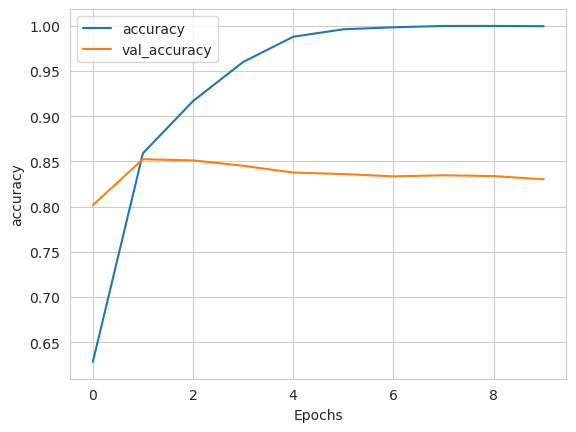

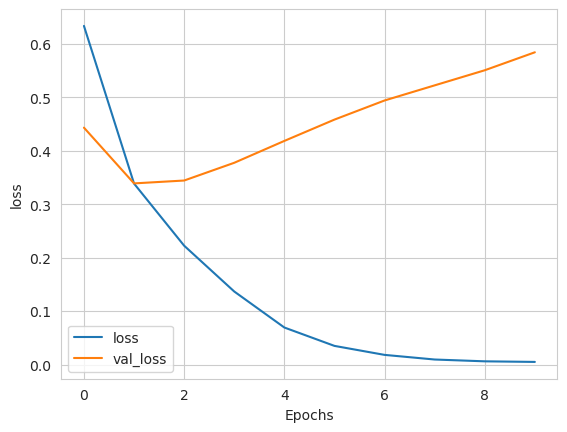

In [8]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

## LSTM

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [9]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = Sequential([Input(shape=(max_length,)),
                         layers.Embedding(vocab_size, embedding_dim,),
                         layers.Bidirectional(layers.LSTM(lstm_dim)),
                         layers.Dense(dense_dim, activation='relu'),
                         layers.Dense(1, activation='sigmoid')])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,941 (675.55 KB)

 Trainable params: 172,941 (675.55 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5825 - loss: 0.6574 - val_accuracy: 0.8165 - val_loss: 0.4496
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8385 - loss: 0.3973 - val_accuracy: 0.8150 - val_loss: 0.4212
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8646 - loss: 0.3422 - val_accuracy: 0.8252 - val_loss: 0.4174
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9056 - loss: 0.2530 - val_accuracy: 0.8318 - val_loss: 0.3796
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9177 - loss: 0.2199 - val_accuracy: 0.8317 - val_loss: 0.3954
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9283 - loss: 0.2011 - val_accuracy: 0.8288 - val_loss: 0.4242
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9420 - loss: 0.1774 - val_accuracy: 0.8287 - val_loss: 0.4410
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9522 - loss: 0.1476 - val_accu

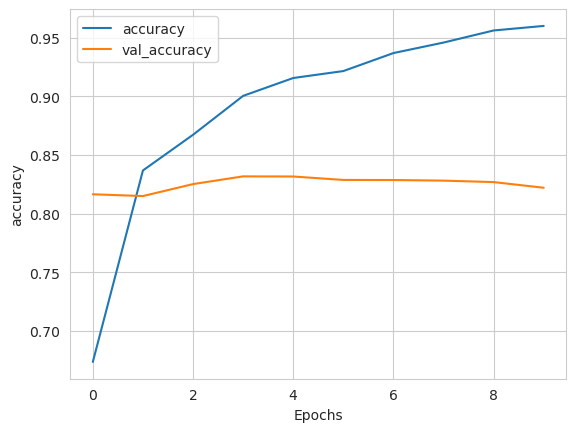

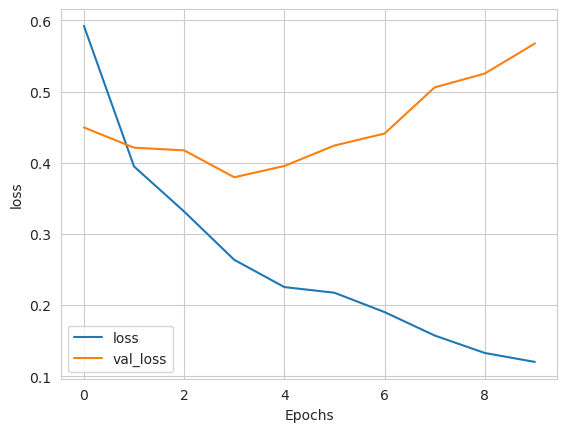

In [11]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

## GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [12]:
# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = Sequential([Input(shape=(max_length,)),
                        layers.Embedding(vocab_size, embedding_dim),
                        layers.Bidirectional(layers.GRU(gru_dim)),
                        layers.Dense(dense_dim, activation='relu'),
                        layers.Dense(1, activation='sigmoid')])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,997 (664.05 KB)

 Trainable params: 169,997 (664.05 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5442 - loss: 0.6782 - val_accuracy: 0.8034 - val_loss: 0.4508
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8483 - loss: 0.3654 - val_accuracy: 0.8252 - val_loss: 0.3850
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8946 - loss: 0.2717 - val_accuracy: 0.8394 - val_loss: 0.3791
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9181 - loss: 0.2157 - val_accuracy: 0.8398 - val_loss: 0.3748
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9275 - loss: 0.1943 - val_accuracy: 0.8363 - val_loss: 0.4379
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9459 - loss: 0.1539 - val_accuracy: 0.8295 - val_loss: 0.4620
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9599 - loss: 0.1198 - val_accuracy: 0.8246 - val_loss: 0.5465
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9676 - loss: 0.0980 - val_accu

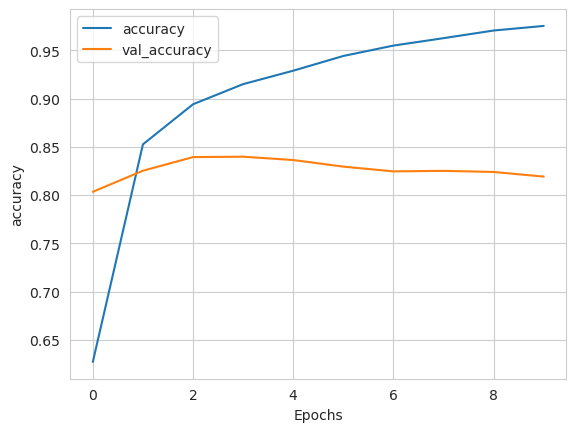

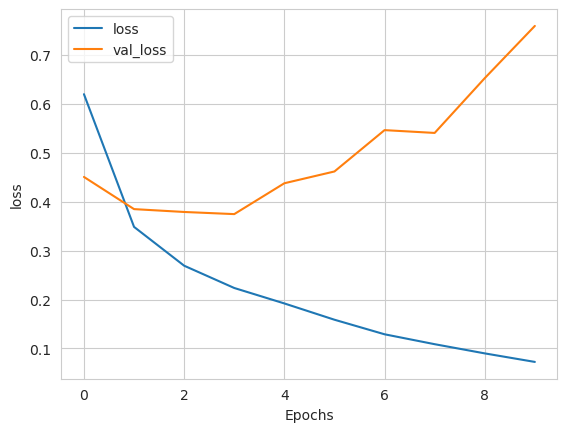

In [14]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

## Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [15]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = Sequential([Input(shape=(max_length,)),
                         layers.Embedding(vocab_size, embedding_dim),
                         layers.Conv1D(filters, kernel_size, activation='relu'),
                         layers.GlobalAveragePooling1D(),
                         layers.Dense(dense_dim, activation='relu'),
                         layers.Dense(1, activation='sigmoid')])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 116, 128)       │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2024-06-13 14:05:01.108650: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-13 14:05:01.197693: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5976 - loss: 0.6610 - val_accuracy: 0.8401 - val_loss: 0.3816
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8664 - loss: 0.3315 - val_accuracy: 0.8506 - val_loss: 0.3460
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9029 - loss: 0.2518 - val_accuracy: 0.8431 - val_loss: 0.3663
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9226 - loss: 0.2097 - val_accuracy: 0.8382 - val_loss: 0.3917
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9291 - loss: 0.1923 - val_accuracy: 0.8350 - val_loss: 0.4213
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9384 - loss: 0.1713 - val_accuracy: 0.8191 - val_loss: 0.4782
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9500 - loss: 0.1450 - val_accuracy: 0.8263 - val_loss: 0.4864
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9486 - loss: 0.1393 - val_accuracy: 0.8223 - val

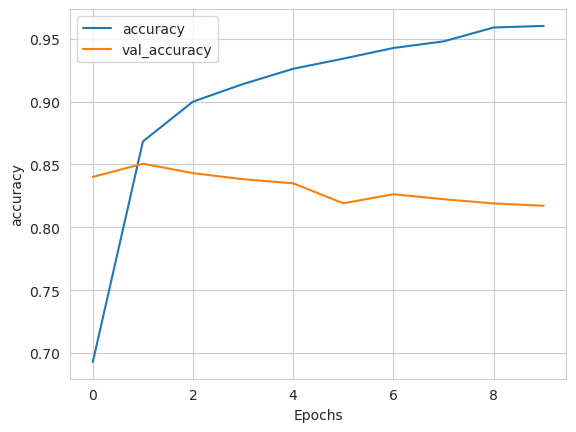

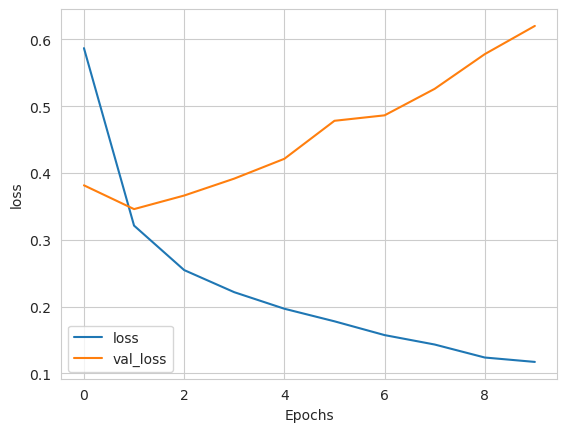

In [17]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')

## Wrap Up

Now that you've seen the results for each model, can you make a recommendation on what works best for this dataset? Do you still get the same results if you tweak some hyperparameters like the vocabulary size? Try tweaking some of the values some more so you can get more insight on what model performs best.